# Review sentiment classification using deep learning models

This project aims to classify the sentiment of hotel reviews from booking.com. The goal is to compare the performance of various deep learning models for this task and identify the most accurate model. This notebook builds on the previous work done on the same dataset, where classification models were employed to perform the same task. By exploring different models, we aim to determine whether deep learning models can outperform the machine learning models in terms of accuracy.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import gensim.downloader as api
import sklearn.metrics as skmetrics
from sklearn.metrics import roc_curve, auc

import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
# import the data
reviews_data = pd.read_csv('/Users/israel/Downloads/Hotel_Reviews_Booking.csv')
reviews_data = reviews_data[:1500]

### Prepare the reveiws dataset
pos_df = reviews_data[['Positive_Review']]
pos_df.columns = ['Review']
pos_df['Sentiment'] = 1 #positive

neg_df = reviews_data[['Negative_Review']]
neg_df.columns = ['Review']
neg_df['Sentiment'] = 0 #negative

clf_df = pd.concat([pos_df,neg_df])
clf_df = clf_df.drop_duplicates().reset_index(drop=True)
clf_df = clf_df.sample(frac=1).reset_index(drop=True)
clf_df

<ipython-input-2-37d60890e97f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pos_df['Sentiment'] = 1 #positive
<ipython-input-2-37d60890e97f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neg_df['Sentiment'] = 0 #negative


,Review,Sentiment
0,Perfect Location Great value Very comfortable...,1
1,The whole hotel was very clean the staff were...,1
2,Bar prices but that s London for you,0
3,Perfect location close to all transports Nice...,1
4,Room was cold the warm air heating struggled ...,0
...,...,...
2472,Reasonable price and good location breakfast ...,1
2473,Great bed bathroom beer garden decor staff an...,1
2474,The only negative was the noise there were bu...,0
2475,Nice variety of foods Good coffee,1


1    1412
0    1065
Name: Sentiment, dtype: int64


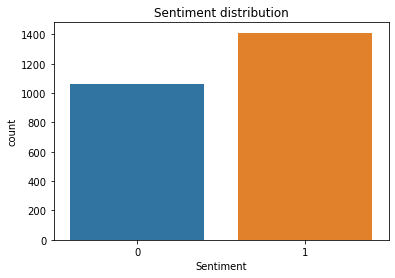

In [3]:
# Check the imbalance in the data
print(clf_df['Sentiment'].value_counts())
sns.countplot(x='Sentiment', data=clf_df)
plt.title('Sentiment distribution')
plt.show()

### Data Preparations

#### Vectorization 

Now we will transform the text into a numerical vector representation. The review is split into individual words and for each word, the vector representation from a pre-trained word2vec model is retrieved and added to the review vector. If the word is not in the word2vec model, it is skipped. After all words in the review have been processed, the review vector is divided by the number of words in the review to normalize it.

In [4]:
# Load the pre-trained word embeddings
word2vec_model = api.load("word2vec-google-news-300")

def review_to_vector(review):
    review_vector = np.zeros((300,))
    word_count = 0
    for word in review.split():
        if word in word2vec_model:
            review_vector += word2vec_model[word]
            word_count += 1
    if word_count != 0:
        review_vector /= word_count
    return review_vector

reviews = clf_df['Review'].apply(review_to_vector)
reviews = np.stack(reviews.values)

Now we will convert the  sentiment labels. We need the labels in this way because neural networks typically expect the output/label data to be in a one-hot encoded format. This format provides a more convenient and efficient representation of the categorical data that the network can learn from. 

In [5]:
def sentiment_to_onehot(sentiment):
    if sentiment == 1:
        return [0, 1]
    else:
        return [1, 0]

sentiments = clf_df['Sentiment'].apply(sentiment_to_onehot)
sentiments = np.stack(sentiments.values)

#### Train/test splitting

In [6]:
X_train = reviews[:int(0.8 * len(reviews))]
y_train = sentiments[:int(0.8 * len(sentiments))]
X_test = reviews[int(0.8 * len(reviews)):]
y_test = sentiments[int(0.8 * len(sentiments)):]

In [7]:
# set parameters
num_epochs = 100
input_size = 300
hidden_size = 128
num_classes = 2
learning_rate = 0.001

In [8]:
# track models performance
log_models = pd.DataFrame(columns=["Model","Accuracy","Precision","Recall","F1-score","AUC","FPR","TPR","Loss_values"])

## Neural networks models

We will define a general function that trains a PyTorch model and evaluates the model's accuracy, precision, recall, f1-score, and ROC and AUC on a test set. We will also record the loss values for each epoch for comparison.

In [9]:
def train_and_evaluate(model_name,model, X_train, y_train, X_test, y_test, criterion, optimizer, num_epochs):
    if model_name in(['Encoder-decoder']):
        encoder = model[0]
        decoder = model[1]
    
    loss_values = []
    for epoch in range(num_epochs):
        # Convert the training data to PyTorch tensors
        inputs = torch.from_numpy(X_train).float()
        if model_name in(['RNN','LSTM','GRU','Encoder-decoder','Encoder-decoder-transformer']):
            # Add an extra dimension to the tensor at position 1
            inputs = inputs.unsqueeze(1) 
        if model_name in(['Transformers']):
            # Add an extra dimension to the tensor at position 0
            inputs = inputs.unsqueeze(0)
        labels = torch.from_numpy(y_train).long()
        
        # Set the gradients to zero
        optimizer.zero_grad()
        if model_name in(['Encoder-decoder']):
            h, c = encoder(inputs)
            outputs = decoder(h[-1, :, :])
        else:
            outputs = model(inputs)
        loss = criterion(outputs, torch.max(labels, 1)[1])
        # Backpropagate the loss
        loss.backward()
        # Update the model weights
        optimizer.step()

        loss_values.append(loss.item())
        if (epoch+1) % 10 == 0:
            print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

    inputs = torch.from_numpy(X_test).float()
    if model_name in(['RNN','LSTM','GRU','Encoder-decoder','Encoder-decoder-transformer']):
        inputs = inputs.unsqueeze(1)
    if model_name in(['Transformers']):
        inputs = inputs.unsqueeze(0)
    labels = torch.from_numpy(y_test.argmax(1)).long()

    with torch.no_grad():
        if model_name in(['Encoder-decoder']):
            h, c = encoder(inputs)
            outputs = decoder(h[-1, :, :])
        else:
            outputs = model(inputs)
        probs = outputs[:, 1].numpy()
        predicted = outputs.argmax(1)
        correct = (predicted == labels).sum().item()
        accuracy = correct / len(labels)
        print('\nAccuracy of the model on the test data: {:.2f}%'.format(accuracy * 100))
        
        precision = skmetrics.precision_score(labels, predicted, average='weighted')
        recall = skmetrics.recall_score(labels, predicted, average='weighted')
        f1 = skmetrics.f1_score(labels, predicted, average='weighted')
        print('Precision of the model: {:.2f}%'.format(precision * 100))
        print('Recall of the model: {:.2f}%'.format(recall * 100))
        print('F1-score of the model: {:.2f}%'.format(f1 * 100))

        fpr, tpr, thresholds = roc_curve(y_test[:, 1], probs)
        roc_auc = auc(fpr, tpr)
        
    return accuracy, precision, recall, f1, roc_auc, fpr, tpr, loss_values

### FFNN

FFNN (feed-forward neural network) is simple and straightforward model and it can be trained relatively quickly. The model consists of multiple fully connected (linear) layers with non-linear activation functions (ReLU) and dropout regularization to prevent overfitting.

In [10]:
class FFNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(FFNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc3(out)
        return out
    
model = FFNN(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train and evaluate the model
accuracy, precision, recall, f1, roc_auc, fpr, tpr, loss_values = train_and_evaluate('FFNN',model, X_train, y_train, X_test, y_test, criterion, optimizer, num_epochs)
log_models.loc[len(log_models)] = ['FFNN',accuracy, precision, recall, f1, roc_auc, fpr, tpr, loss_values]

Epoch [10/100], Loss: 0.6560
Epoch [20/100], Loss: 0.5561
Epoch [30/100], Loss: 0.4200
Epoch [40/100], Loss: 0.3004
Epoch [50/100], Loss: 0.2434
Epoch [60/100], Loss: 0.2052
Epoch [70/100], Loss: 0.1940
Epoch [80/100], Loss: 0.1721
Epoch [90/100], Loss: 0.1474
Epoch [100/100], Loss: 0.1344

Accuracy of the model on the test data: 91.94%
Precision of the model: 91.93%
Recall of the model: 91.94%
F1-score of the model: 91.93%


### RNN-based models

#### Vanilla RNN

The RNN architecture captures sequential information of the text data by processing each word of the sequence sequentially and using its hidden state to pass information to the next word.

In [11]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, num_layers=2):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(p=0.1)
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        out, _ = self.rnn(x, h0)
        out = self.dropout(out)
        out = self.fc(out[:, -1, :])
        return out

model = RNN(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train and evaluate the model
accuracy, precision, recall, f1, roc_auc, fpr, tpr, loss_values = train_and_evaluate('RNN',model, X_train, y_train, X_test, y_test, criterion, optimizer, num_epochs)
log_models.loc[len(log_models)] = ['RNN',accuracy, precision, recall, f1, roc_auc, fpr, tpr, loss_values]

Epoch [10/100], Loss: 0.6173
Epoch [20/100], Loss: 0.5321
Epoch [30/100], Loss: 0.4483
Epoch [40/100], Loss: 0.3775
Epoch [50/100], Loss: 0.3240
Epoch [60/100], Loss: 0.2876
Epoch [70/100], Loss: 0.2635
Epoch [80/100], Loss: 0.2466
Epoch [90/100], Loss: 0.2346
Epoch [100/100], Loss: 0.2241

Accuracy of the model on the test data: 92.74%
Precision of the model: 92.75%
Recall of the model: 92.74%
F1-score of the model: 92.73%


#### Bi-RNN

The bi-directional nature of the RNN allows the model to take into account the context of the current word in both the forward and backward directions. Additionally, the linear layer at the end of the model can combine information from both directions to make a prediction.

In [12]:
class BiRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(BiRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size*2, num_classes)
        
    def forward(self, x):
        h0 = torch.zeros(2, x.size(0), self.hidden_size)
        out, _ = self.rnn(x, h0)
        out = self.fc(torch.cat((out[:, -1, :self.hidden_size], out[:, 0, self.hidden_size:]), dim=1))
        return out

model = BiRNN(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train and evaluate the model
accuracy, precision, recall, f1, roc_auc, fpr, tpr, loss_values = train_and_evaluate('RNN',model, X_train, y_train, X_test, y_test, criterion, optimizer, num_epochs)
log_models.loc[len(log_models)] = ['Bi-RNN',accuracy, precision, recall, f1, roc_auc, fpr, tpr, loss_values]

Epoch [10/100], Loss: 0.5759
Epoch [20/100], Loss: 0.4610
Epoch [30/100], Loss: 0.3683
Epoch [40/100], Loss: 0.3042
Epoch [50/100], Loss: 0.2662
Epoch [60/100], Loss: 0.2434
Epoch [70/100], Loss: 0.2284
Epoch [80/100], Loss: 0.2166
Epoch [90/100], Loss: 0.2066
Epoch [100/100], Loss: 0.1980

Accuracy of the model on the test data: 92.34%
Precision of the model: 92.34%
Recall of the model: 92.34%
F1-score of the model: 92.33%


#### LSTM

The LSTM architecture is designed to address the vanishing gradient problem in RNN. It can capture long-term dependencies in sequential data and selectively remember or forget information as needed.

In [13]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        c0 = torch.zeros(1, x.size(0), self.hidden_size)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train and evaluate the model
accuracy, precision, recall, f1, roc_auc, fpr, tpr, loss_values = train_and_evaluate('LSTM',model, X_train, y_train, X_test, y_test, criterion, optimizer, num_epochs)
log_models.loc[len(log_models)] = ['LSTM',accuracy, precision, recall, f1, roc_auc, fpr, tpr, loss_values]

Epoch [10/100], Loss: 0.6645
Epoch [20/100], Loss: 0.6276
Epoch [30/100], Loss: 0.5769
Epoch [40/100], Loss: 0.5086
Epoch [50/100], Loss: 0.4355
Epoch [60/100], Loss: 0.3699
Epoch [70/100], Loss: 0.3179
Epoch [80/100], Loss: 0.2817
Epoch [90/100], Loss: 0.2579
Epoch [100/100], Loss: 0.2412

Accuracy of the model on the test data: 92.34%
Precision of the model: 92.34%
Recall of the model: 92.34%
F1-score of the model: 92.33%


#### Nested LSTM

In the The nested LSTM architecture, we are using two LSTM layers which can learn higher-level representations of the input, where the output of the first LSTM layer serves as the input to the second LSTM layer. This allows the model to capture long-term dependencies and relationships within the input sequences.

In [14]:
class NestedLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NestedLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        c0 = torch.zeros(1, x.size(0), self.hidden_size)
        out, (h_n, c_n) = self.lstm1(x, (h0, c0))
        out, _ = self.lstm2(out, (h_n, c_n))
        out = self.fc(out[:, -1, :])
        return out

model = NestedLSTM(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train and evaluate the model
accuracy, precision, recall, f1, roc_auc, fpr, tpr, loss_values = train_and_evaluate('LSTM',model, X_train, y_train, X_test, y_test, criterion, optimizer, num_epochs)
log_models.loc[len(log_models)] = ['Nested LSTM',accuracy, precision, recall, f1, roc_auc, fpr, tpr, loss_values]

Epoch [10/100], Loss: 0.6656
Epoch [20/100], Loss: 0.6070
Epoch [30/100], Loss: 0.4805
Epoch [40/100], Loss: 0.3450
Epoch [50/100], Loss: 0.2569
Epoch [60/100], Loss: 0.2238
Epoch [70/100], Loss: 0.1997
Epoch [80/100], Loss: 0.1814
Epoch [90/100], Loss: 0.1639
Epoch [100/100], Loss: 0.1471

Accuracy of the model on the test data: 92.54%
Precision of the model: 92.54%
Recall of the model: 92.54%
F1-score of the model: 92.54%


#### GRU

The GRU is similar to the LSTM in that it can handle long-term dependencies but has fewer parameters, which can make it easier to train and faster to run.

In [15]:
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(GRU, self).__init__()
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])
        return out

model = GRU(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train and evaluate the model
accuracy, precision, recall, f1, roc_auc, fpr, tpr, loss_values = train_and_evaluate('GRU',model, X_train, y_train, X_test, y_test, criterion, optimizer, num_epochs)
log_models.loc[len(log_models)] = ['GRU',accuracy, precision, recall, f1, roc_auc, fpr, tpr, loss_values]

Epoch [10/100], Loss: 0.6456
Epoch [20/100], Loss: 0.5885
Epoch [30/100], Loss: 0.5140
Epoch [40/100], Loss: 0.4374
Epoch [50/100], Loss: 0.3709
Epoch [60/100], Loss: 0.3192
Epoch [70/100], Loss: 0.2833
Epoch [80/100], Loss: 0.2592
Epoch [90/100], Loss: 0.2425
Epoch [100/100], Loss: 0.2300

Accuracy of the model on the test data: 92.74%
Precision of the model: 92.75%
Recall of the model: 92.74%
F1-score of the model: 92.73%


#### Encoder-decoder

The Encoder-decoder architecture allows the model to encode the input sequence into a fixed-size vector representation, and then decode this representation into the output sequence, thus capturing long-term dependencies. Here the encoder uses an LSTM to encode the input sequence and outputs the final hidden and cell state, which are then used as the initial hidden and cell state for the decoder. The decoder we defined here is a simple linear layer that takes the final hidden state of the encoder as input and predicts the sentiment class.

In [16]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        
    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        c0 = torch.zeros(1, x.size(0), self.hidden_size)
        out, (h, c) = self.lstm(x, (h0, c0))
        return h, c

class Decoder(nn.Module):
    def __init__(self, hidden_size, num_classes):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        out = self.fc(x)
        return out

encoder = Encoder(input_size, hidden_size)
decoder = Decoder(hidden_size, num_classes)
model = [encoder, decoder]
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=learning_rate)

# Train and evaluate the model
accuracy, precision, recall, f1, roc_auc, fpr, tpr, loss_values = train_and_evaluate('Encoder-decoder',model, X_train, y_train, X_test, y_test, criterion, optimizer, num_epochs)
log_models.loc[len(log_models)] = ['Encoder-decoder',accuracy, precision, recall, f1, roc_auc, fpr, tpr, loss_values]

Epoch [10/100], Loss: 0.6638
Epoch [20/100], Loss: 0.6267
Epoch [30/100], Loss: 0.5732
Epoch [40/100], Loss: 0.5031
Epoch [50/100], Loss: 0.4291
Epoch [60/100], Loss: 0.3640
Epoch [70/100], Loss: 0.3133
Epoch [80/100], Loss: 0.2784
Epoch [90/100], Loss: 0.2554
Epoch [100/100], Loss: 0.2393

Accuracy of the model on the test data: 92.34%
Precision of the model: 92.34%
Recall of the model: 92.34%
F1-score of the model: 92.33%


#### MoE Encoder-decoder

The MoE Encoder-decoder architecture allows the model to learn multiple experts that can each capture different aspects of the data. The MoE mechanism enables the model to dynamically assign weights to the outputs of the experts based on the input, which can improve the model's ability to handle diverse input distributions.

In [17]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        
    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        c0 = torch.zeros(1, x.size(0), self.hidden_size)
        out, (h, c) = self.lstm(x, (h0, c0))
        return h, c

class MoE(nn.Module):
    def __init__(self, num_experts, hidden_size):
        super(MoE, self).__init__()
        self.num_experts = num_experts
        self.hidden_size = hidden_size
        self.gate = nn.Linear(hidden_size, num_experts)
        self.experts = nn.ModuleList([Decoder(hidden_size, num_classes) for _ in range(num_experts)])
        
    def forward(self, x):
        gates = F.softmax(self.gate(x), dim=1)
        expert_outputs = [expert(x) for expert in self.experts]
        outputs = torch.stack(expert_outputs, dim=1)
        weighted_outputs = torch.bmm(gates.unsqueeze(1), outputs).squeeze(1)
        return weighted_outputs    

class Decoder(nn.Module):
    def __init__(self, hidden_size, num_classes):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        out = self.fc(x)
        return out

num_experts=3
encoder = Encoder(input_size, hidden_size)
moe = MoE(num_experts, hidden_size)
decoder = Decoder(hidden_size, num_classes)
model = nn.Sequential(encoder, moe, decoder)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train and evaluate the model
accuracy, precision, recall, f1, roc_auc, fpr, tpr, loss_values = train_and_evaluate('Encoder-decoder',model, X_train, y_train, X_test, y_test, criterion, optimizer, num_epochs)
log_models.loc[len(log_models)] = ['MoE Encoder-decoder',accuracy, precision, recall, f1, roc_auc, fpr, tpr, loss_values]

Epoch [10/100], Loss: 0.6721
Epoch [20/100], Loss: 0.6406
Epoch [30/100], Loss: 0.5943
Epoch [40/100], Loss: 0.5228
Epoch [50/100], Loss: 0.4397
Epoch [60/100], Loss: 0.3616
Epoch [70/100], Loss: 0.2979
Epoch [80/100], Loss: 0.2548
Epoch [90/100], Loss: 0.2282
Epoch [100/100], Loss: 0.2109

Accuracy of the model on the test data: 92.54%
Precision of the model: 92.54%
Recall of the model: 92.54%
F1-score of the model: 92.53%


### Transformers-based models

#### Transformer-encoder

The Transformer-encoder architecture uses self-attention mechanisms that can capture the dependencies between words in a sentence. Additionally, the model is able to process variable-length input sequences without the need for recurrent connections, which can help speed up training and inference time.

In [18]:
class TransformerEncoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, num_layers=2, nhead=8):
        super(TransformerEncoder, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.num_classes = num_classes
        self.encoder = nn.Linear(input_size, hidden_size)
        self.transformer_encoder = nn.TransformerEncoder(nn.TransformerEncoderLayer(hidden_size, nhead=nhead), num_layers=num_layers)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.encoder(x)
        x = x.permute(1,0,2) #(batch, sequence, feature)
        x = self.transformer_encoder(x)
        x = x.permute(1,0,2) #(sequence, batch, feature)
        x = self.fc(x[-1, :, :])
        return x

model = TransformerEncoder(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train and evaluate the model
accuracy, precision, recall, f1, roc_auc, fpr, tpr, loss_values = train_and_evaluate('Transformers',model, X_train, y_train, X_test, y_test, criterion, optimizer, num_epochs)
log_models.loc[len(log_models)] = ['Transformer-encoder',accuracy, precision, recall, f1, roc_auc, fpr, tpr, loss_values]

Epoch [10/100], Loss: 0.6748
Epoch [20/100], Loss: 0.6749
Epoch [30/100], Loss: 0.6023
Epoch [40/100], Loss: 0.3186
Epoch [50/100], Loss: 0.2246
Epoch [60/100], Loss: 0.1803
Epoch [70/100], Loss: 0.1502
Epoch [80/100], Loss: 0.1135
Epoch [90/100], Loss: 0.0817
Epoch [100/100], Loss: 0.0587

Accuracy of the model on the test data: 91.33%
Precision of the model: 91.47%
Recall of the model: 91.33%
F1-score of the model: 91.29%


#### Multi-head attention transformer

The multi-head attention transformer takes the input tensor and computes the dot product of query, key, and value tensors, whereas in the transformer-encoder, the attention mechanism is separated into two parts: multi-head self-attention and a position-wise fully connected feed-forward network. Additionally, the multi-head attention transformer has only one attention layer, while the transformer-encoder have multiple layers.

In [19]:
class MultiHeadAttentionTransformer(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, nhead=8):
        super(MultiHeadAttentionTransformer, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.num_classes = num_classes
        self.encoder = nn.Linear(input_size, hidden_size)
        self.multihead_attention = nn.MultiheadAttention(hidden_size, nhead)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.encoder(x)
        x, _ = self.multihead_attention(x, x, x)
        x = self.fc(x[-1, :, :])
        return x

model = MultiHeadAttentionTransformer(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train and evaluate the model
accuracy, precision, recall, f1, roc_auc, fpr, tpr, loss_values = train_and_evaluate('Transformers',model, X_train, y_train, X_test, y_test, criterion, optimizer, num_epochs)
log_models.loc[len(log_models)] = ['Multi-head attention transformer',accuracy, precision, recall, f1, roc_auc, fpr, tpr, loss_values]

Epoch [10/100], Loss: 0.5870
Epoch [20/100], Loss: 0.3466
Epoch [30/100], Loss: 0.2614
Epoch [40/100], Loss: 0.2238
Epoch [50/100], Loss: 0.2028
Epoch [60/100], Loss: 0.1822
Epoch [70/100], Loss: 0.1649
Epoch [80/100], Loss: 0.1481
Epoch [90/100], Loss: 0.1325
Epoch [100/100], Loss: 0.1236

Accuracy of the model on the test data: 91.13%
Precision of the model: 91.14%
Recall of the model: 91.13%
F1-score of the model: 91.13%


#### Encoder-decoder transformer 

The encoder-decoder transformer architecture use the attention mechanism. In this architecture, the encoder uses the transformer network to encode the input sequence, while the decoder uses another transformer network to generate the output sequence.

In [20]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=2, nhead=8):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.encoder = nn.Linear(input_size, hidden_size)
        self.transformer_encoder = nn.TransformerEncoder(nn.TransformerEncoderLayer(hidden_size, nhead=nhead), num_layers=num_layers)

    def forward(self, x):
        x = self.encoder(x)
        x = x.permute(1,0,2) #(batch, sequence, feature)
        x = self.transformer_encoder(x)
        return x

class Decoder(nn.Module):
    def __init__(self, hidden_size, num_classes, num_layers=2, nhead=8):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.decoder = nn.Linear(hidden_size, num_classes)
        self.transformer_decoder = nn.TransformerDecoder(nn.TransformerDecoderLayer(hidden_size, nhead=nhead), num_layers=num_layers)

    def forward(self, x, encoder_output):
        x = x.unsqueeze(0) #(1, batch, feature)
        x = self.transformer_decoder(x, encoder_output)
        x = self.decoder(x[-1, :, :])
        return x

class Transformer(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, num_layers=2, nhead=8):
        super(Transformer, self).__init__()
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.encoder = Encoder(input_size, hidden_size, num_layers, nhead)
        self.decoder = Decoder(hidden_size, num_classes, num_layers, nhead)

    def forward(self, x):
        encoder_output = self.encoder(x)
        decoder_output = self.decoder(encoder_output[-1, :, :], encoder_output)
        return decoder_output

model = Transformer(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train and evaluate the model
accuracy, precision, recall, f1, roc_auc, fpr, tpr, loss_values = train_and_evaluate('Encoder-decoder-transformer',model, X_train, y_train, X_test, y_test, criterion, optimizer, num_epochs)
log_models.loc[len(log_models)] = ['Encoder-decoder transformer',accuracy, precision, recall, f1, roc_auc, fpr, tpr, loss_values]

Epoch [10/100], Loss: 0.7057
Epoch [20/100], Loss: 0.6874
Epoch [30/100], Loss: 0.6836
Epoch [40/100], Loss: 0.6819
Epoch [50/100], Loss: 0.6806
Epoch [60/100], Loss: 0.6793
Epoch [70/100], Loss: 0.6192
Epoch [80/100], Loss: 0.6258
Epoch [90/100], Loss: 0.2616
Epoch [100/100], Loss: 0.2228

Accuracy of the model on the test data: 92.34%
Precision of the model: 92.51%
Recall of the model: 92.34%
F1-score of the model: 92.30%


### Model comparison

In [21]:
log_models = log_models.set_index('Model')
log_models = log_models.sort_values(by="F1-score",ascending=False)
log_models

,Accuracy,Precision,Recall,F1-score,AUC,FPR,TPR,Loss_values
Model,,,,,,,,
RNN,0.927419,0.927494,0.927419,0.927319,0.966918,"[0.0, 0.0, 0.0, 0.004484304932735426, 0.004484...","[0.0, 0.003663003663003663, 0.4542124542124542...","[0.6922503709793091, 0.6804596185684204, 0.670..."
GRU,0.927419,0.927494,0.927419,0.927319,0.968823,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.004484304932735426...","[0.0, 0.003663003663003663, 0.3186813186813186...","[0.6963319778442383, 0.6890884041786194, 0.682..."
Nested LSTM,0.925403,0.925374,0.925403,0.925354,0.965505,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.004484304932735426...","[0.0, 0.003663003663003663, 0.3626373626373626...","[0.6961032152175903, 0.6927406787872314, 0.689..."
MoE Encoder-decoder,0.925403,0.925425,0.925403,0.925319,0.968807,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.004484304932735426...","[0.0, 0.003663003663003663, 0.336996336996337,...","[0.6934943795204163, 0.6912226676940918, 0.688..."
LSTM,0.923387,0.923372,0.923387,0.923319,0.969464,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.004484304932735426...","[0.0, 0.003663003663003663, 0.3516483516483517...","[0.6990910768508911, 0.6949828267097473, 0.691..."
Bi-RNN,0.923387,0.923449,0.923387,0.923281,0.965637,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.004484304932735426...","[0.0, 0.003663003663003663, 0.2820512820512820...","[0.6899418830871582, 0.6712309122085571, 0.657..."
Encoder-decoder,0.923387,0.923449,0.923387,0.923281,0.968906,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.004484304932735426...","[0.0, 0.003663003663003663, 0.336996336996337,...","[0.698454737663269, 0.6941095590591431, 0.6899..."
Encoder-decoder transformer,0.923387,0.925109,0.923387,0.922999,0.953974,"[0.0, 0.0, 0.0, 0.004484304932735426, 0.004484...","[0.0, 0.003663003663003663, 0.0622710622710622...","[0.7025518417358398, 0.8063535690307617, 3.188..."
FFNN,0.919355,0.919333,0.919355,0.919283,0.962154,"[0.0, 0.0, 0.0, 0.004484304932735426, 0.004484...","[0.0, 0.003663003663003663, 0.2747252747252747...","[0.6909021735191345, 0.688519299030304, 0.6840..."


##### Metrics scores

<Figure size 504x432 with 0 Axes>

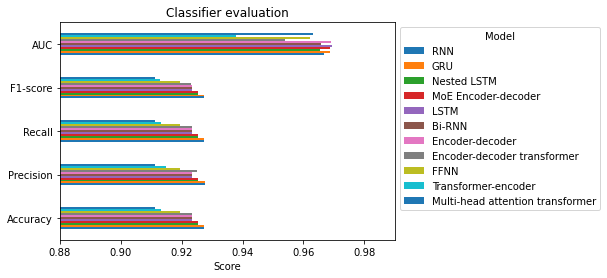

In [22]:
plt.figure(figsize=(7, 6))
log_models[['Accuracy','Precision','Recall','F1-score','AUC']].T.plot.barh()
plt.title('Classifier evaluation')
plt.legend(title='Model', bbox_to_anchor=(1, 1))
plt.xlabel('Score')
plt.xlim((0.88,0.99))
plt.show()

##### ROC curve

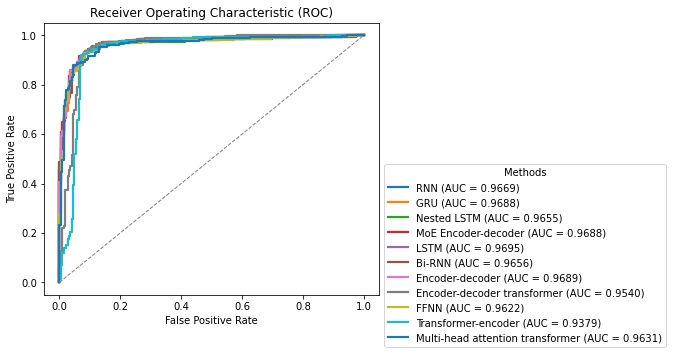

In [23]:
log_models = log_models.reset_index()
plt.figure(figsize=(6, 5))
for model in range(len(log_models)):
    plt.plot(log_models['FPR'][model], log_models['TPR'][model], lw=2.2, label='{} (AUC = {:.4f})'.format(log_models['Model'][model],log_models['AUC'][model]))
plt.plot([0, 1], [0, 1], linestyle='--', lw=1, color='gray')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(title='Methods', bbox_to_anchor=(1, 0.5))
plt.show()

##### Training loss vs epochs

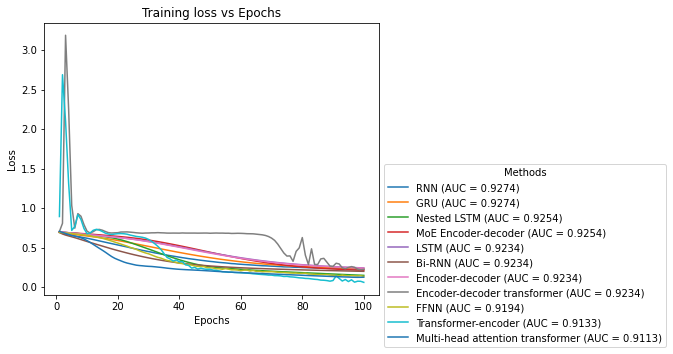

In [24]:
plt.figure(figsize=(6, 5))
for model in range(len(log_models)):
    plt.plot(range(1, num_epochs+1), log_models['Loss_values'][model], label='{} (AUC = {:.4f})'.format(log_models['Model'][model],log_models['Accuracy'][model]))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training loss vs Epochs')
plt.legend(title='Methods', bbox_to_anchor=(1, 0.5))
plt.show()

Based on the performance metrics shown, there is no significant difference between the models. The RNN, GRU, and Nested LSTM models perform best in terms of accuracy and F1-score. MoE encoder-decoder, LSTM, Bi-RNN, and encoder-decoder models have slightly lower scores but are still reasonable choices. The encoder-decoder transformer, FFNN, transformer-encoder, and multi-head attention transformer models show lower performance and thus may not be the best choices for this particular sentiment analysis task.

It should be noted that in this project, the models were trained without using batches. This means that the entire training dataset was fed to the model at once, which can lead to memory issues for large datasets. In our case, the dataset is not very large, and the training process was still manageable even without using batches.

In comparison to our previous notebook where we explored machine learning classification models, the deep learning models examined in this notebook have shown to outperform the majority of them. It's worth noting that SVM did provide a similar level of accuracy.